<a href="https://colab.research.google.com/github/tanishy7777/RNN_NameClassification/blob/main/RNN_NameClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

In [17]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('./data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix (line/word_length x (1 x n_letters)).

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

There is a builtin RNN class in pytorch but the below implementation is from scratch.

In [39]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)  #  output_dim = 1 x 18, since 18 classes(countries)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    # output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

category_lines, all_categories = load_data()
n_categories = len(all_categories)   # 18 categories

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# # one step
# input_tensor = letter_to_tensor('A')
# hidden_tensor = rnn.init_hidden()

# output, next_hidden = rnn(input_tensor, hidden_tensor)
# print(output.shape)
# print(next_hidden.shape)

# # whole sequence/name
# input_tensor = line_to_tensor('Albert')
# hidden_tensor = rnn.init_hidden()

# output, next_hidden = rnn(input_tensor[0], hidden_tensor)
# print(output.shape)
# print(next_hidden.shape)



In [40]:
# output is 1x18 and the entries are the log of probabilities of each class
def category_from_output(output):
  category_idx = torch.argmax(output).item()
  return all_categories[category_idx]
print(category_from_output(output))

Korean


NLLLOSS and cross entropy both are used for multiclass classification problems

cross entropy -> Logsoftmax + NLLLOSS

NLLLOSS expects Log probabilities as inputs

In [41]:
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr)

5000 5.0 1.6150 Luo / Chinese CORRECT
10000 10.0 2.6858 Silveira / Japanese WRONG (Portuguese)
15000 15.0 0.9665 Zhao / Chinese CORRECT
20000 20.0 1.3452 Slepicka / Polish WRONG (Czech)
25000 25.0 1.8112 Fallon / Scottish WRONG (English)
30000 30.0 1.6941 De la fontaine / Portuguese WRONG (French)
35000 35.0 1.9429 Patzevich / Czech WRONG (Russian)
40000 40.0 0.1729 Avdulov / Russian CORRECT
45000 45.0 1.8031 Abadi / Japanese WRONG (Arabic)
50000 50.0 1.0083 Klimek / Czech WRONG (Polish)
55000 55.00000000000001 2.9411 Bohm / Vietnamese WRONG (German)
60000 60.0 2.9608 Beveridge / French WRONG (English)
65000 65.0 1.6029 Gallchobhar / French WRONG (Irish)
70000 70.0 0.7793 Alves / Portuguese CORRECT
75000 75.0 0.5642 Harb / Arabic CORRECT
80000 80.0 0.8737 Havlatova / Czech CORRECT
85000 85.0 2.1115 Hall / Scottish WRONG (German)
90000 90.0 1.8291 Paternoster / Dutch WRONG (French)
95000 95.0 4.0916 Names / Portuguese WRONG (Irish)
100000 100.0 0.6154 Wojda / Polish CORRECT


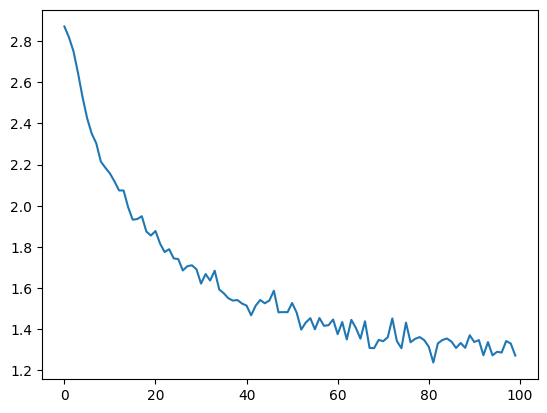

In [42]:
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()
                # length of the name
  for i in range(line_tensor.shape[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_losses)
plt.show()


In [43]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)  # (line_size x 1 x n_letters) => (batch of one-hot vectors)
        hidden = rnn.init_hidden()    # since we dont want the prediction to be affected by older sequences,
                                      # it should be based on the input only

        for i in range(line_tensor.shape[0]):
            output, hidden = rnn(line_tensor[i], hidden)    # pass the sequence/line to RNN character by character
                                                            # hidden state is updated after passing every character
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


Input:mamamia

> mamamia
Spanish
Input:senorit

> senorit
French
Input:senorita

> senorita
Italian
Input:albert

> albert
French
Input:rosa

> rosa
Spanish
Input:quit
